# Data Analysis Notebook For Hartree-Fock Stability
---

This notebook and the corresponding python file at pyfiles.HFSAnalyzer contain all data analysis and plotting scripts used in the Hatree-Fock Stability of the Homogeneous Electron Gas (HEG). The Data all comes from the executables in the src directory of the project. The logfiles are all in .json format, allowing for easy parsing, while also being human readable (except some large arrays). 

In [1]:
import glob
import json
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

html = get_ipython().display_formatter.formatters['text/html'] 
    
def named_df_repr_html_(obj):
    try:
        return '<strong>{}:</strong>'.format(obj.name) + obj._repr_html_()
    except AttributeError:
        return obj._repr_html_()
    
def series_repr_html_(obj):
    df = pd.DataFrame(obj)
    if obj.name is not None:
        df.columns = ['{}'.format(obj.name)]
    else:
        df.columns = ['{}'.format(obj.dtype)]
    return df._repr_html_()

def DataFrameGroupByReprHTML(self):
    result = []
    for group, df in self:
        result.append('<h2>{}</h2>'.format(group) + df._repr_html_())
    return ''.join(result)
    
html.for_type(pd.core.groupby.DataFrameGroupBy, DataFrameGroupByReprHTML) 
html.for_type(pd.DataFrame, named_df_repr_html_) 
html.for_type(pd.Series, series_repr_html_) 

## Load the Data
---

The data is parsed and collected in a pandas dataframe

In [2]:
def multiple_replace(string, replacements):
    """Replace all occurances of replacements' keys in string with corresponding values."""
    d = dict(replacements)
    pattern = re.compile(r'\b(' + '|'.join(d.keys()) + r')\b')
    return pattern.sub(lambda x: d[x.group()], string)

dicts = []
for fname in glob.glob('/home/evan/Documents/HF-Stability/data/*.json'):
    with open(fname, 'r') as f:
        s = f.read()
    corrected = multiple_replace(s, {'inf': 'Infinity', 'nan': 'NaN'})        
    dicts.append(json.loads(corrected))
    
df = pd.DataFrame(dicts)
df.head()

,File,NDIM,N_MV_PROD,Nexc,Nk,Nmat,Nocc,Nvir,build_date,computation_finished,...,kmax,mv_time,mycase,n_procs,num_guess_evecs,rs,total_calculation_time,twoE_parameter_1dCase,use_delta_1D,vol
0,HFS_3d_16Nk_2-0rs.json,3,0,2515,16,2515,251,469,Sep 11 2017-11:47:45,Wed Sep 27 14:24:50 2017,...,1.919159,0.0,cRHF2cUHF,2048,100,2.0000,43.1122,1.0,0,16822.181462
1,HFS_3d_16Nk_4-5rs.json,3,0,2515,16,2515,251,469,Sep 11 2017-11:47:45,Wed Sep 27 13:36:55 2017,...,0.852960,0.0,cRHF2cUHF,2048,100,4.5000,50.3638,1.0,0,191615.160720
2,HFS_scaling_test_224.json,3,0,6095,20,6095,485,895,Sep 11 2017-11:47:45,Wed Sep 20 15:23:05 2017,...,3.198599,0.0,cRHF2cUHF,224,100,1.2000,76.5161,1.0,0,7021.082590
3,HFS_1D_200Nk_0.0183rs_rev2.json,1,0,9999,200,9999,99,101,Sep 11 2017-11:45:37,Mon Apr 2 16:27:41 2018,...,85.835908,0.0,cRHF2cUHF,128,100,0.0183,26.7454,1.0,1,7.246800
4,HFS_3d_24Nk_1-0rs.json,3,0,13379,24,13379,895,1721,Sep 11 2017-11:47:45,Wed Sep 27 13:25:20 2017,...,3.838319,0.0,cRHF2cUHF,2048,100,1.0000,113.687,1.0,0,7497.934467


## Ensure expected typecasts

In [3]:
df['Nk'] = df['Nk'].astype(int)
df['NDIM'] = df['NDIM'].astype(int)
df['mycase'] = df['mycase'].astype(str).str.lstrip().str.rstrip()    
df['rs'] = df['rs'].astype(float)
df['File'] = df['File'].astype(str)
df['total_calculation_time'] = df['total_calculation_time'].astype(float)
df['computation_started'] = pd.to_datetime(df['computation_started'])
df['computation_finished'] = pd.to_datetime(df['computation_finished'])
df['build_date'] = pd.to_datetime(df['build_date'].str.replace('-', ' '))

df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Can now use .dropna() to drop +/- inf.

mask = df['File'].str.contains('scaling_test')
scaling_test = df[mask]
df = df[np.logical_not(mask)]
df.head()

,File,NDIM,N_MV_PROD,Nexc,Nk,Nmat,Nocc,Nvir,build_date,computation_finished,...,kmax,mv_time,mycase,n_procs,num_guess_evecs,rs,total_calculation_time,twoE_parameter_1dCase,use_delta_1D,vol
0,HFS_3d_16Nk_2-0rs.json,3,0,2515,16,2515,251,469,2017-09-11 11:47:45,2017-09-27 14:24:50,...,1.919159,0.0,cRHF2cUHF,2048,100,2.0000,43.1122,1.0,0,16822.181462
1,HFS_3d_16Nk_4-5rs.json,3,0,2515,16,2515,251,469,2017-09-11 11:47:45,2017-09-27 13:36:55,...,0.852960,0.0,cRHF2cUHF,2048,100,4.5000,50.3638,1.0,0,191615.160720
3,HFS_1D_200Nk_0.0183rs_rev2.json,1,0,9999,200,9999,99,101,2017-09-11 11:45:37,2018-04-02 16:27:41,...,85.835908,0.0,cRHF2cUHF,128,100,0.0183,26.7454,1.0,1,7.246800
4,HFS_3d_24Nk_1-0rs.json,3,0,13379,24,13379,895,1721,2017-09-11 11:47:45,2017-09-27 13:25:20,...,3.838319,0.0,cRHF2cUHF,2048,100,1.0000,113.6870,1.0,0,7497.934467
6,HFS_2d_44Nk_16.0_rs_aprRev.json,2,0,9471,44,9471,373,551,2017-09-11 11:46:41,2018-04-17 17:21:38,...,0.176777,0.0,cRHF2cUHF,128,100,16.0000,847.7460,1.0,1,599968.798612


## Clean Data and simple calcs


In [4]:
# Remove data with critical values missing
df.dropna(axis='rows', subset=['NDIM', 'rs', 'Nk'], inplace=True)

# Remove data from before April revision
df = df[np.logical_not((df.computation_started < pd.to_datetime('2018-04-01')) & (df.NDIM == 1))] 

# Of course use_delta_1D must be false for ndim=2, 3
df.loc[np.logical_or(df['NDIM'] == 2, df['NDIM'] == 3), 'use_delta_1D'] = False
df['use_delta_1D'] = df['use_delta_1D'].astype(bool)

df['Nkpoints'] = df['Nk'] ** df['NDIM']

# remove duplicates while keeping the most recent one
df = df.sort_values('computation_finished', ascending=False)
df = df.drop_duplicates(subset=['NDIM', 'rs', 'Nk', 'mycase', 'twoE_parameter_1dCase', 'use_delta_1D'], keep='first')

# The matrix was diagonalized by factoring into A + B and A - B for singlet and triplet cases
# It seems very likely that the offdiagonal components mean that these have equivalent
# eigenvalues, but I was unable to prove this definitively. To be safe, I just did all cases. 
# Thus the actual instability eigenvalue is the minimum of the eigenvalues of A + B and A - B. 
df['triplet_instability'] = df[['dav_triplet_a_minus_b', 'dav_triplet_a_plus_b']].min(axis=1)
df['singlet_instability'] = df[['dav_singlet_a_minus_b', 'dav_singlet_a_plus_b']].min(axis=1)

df['time'] = (df['computation_finished'] - df['computation_started']).dt.total_seconds()

df.head()

,File,NDIM,N_MV_PROD,Nexc,Nk,Nmat,Nocc,Nvir,build_date,computation_finished,...,num_guess_evecs,rs,total_calculation_time,twoE_parameter_1dCase,use_delta_1D,vol,Nkpoints,triplet_instability,singlet_instability,time
49,HFS_3d_32Nk_6.0_rs_aprRev.json,3,0,42079,32,42079,2103,4073,2017-09-11 11:47:45,2018-04-18 09:31:49,...,100,6.0,15843.10,1.0,False,3.805499e+06,32768,-0.015945,-0.004470,15844.0
228,HFS_2d_54Nk_15.0_rs_aprRev.json,2,0,17875,54,17875,577,881,2017-09-11 11:46:41,2018-04-18 09:09:55,...,100,15.0,5750.95,1.0,False,8.157145e+05,2916,-0.060518,-0.010967,5751.0
271,HFS_2d_64Nk_7.0_rs_aprRev.json,2,0,29297,64,29297,793,1191,2017-09-11 11:46:41,2018-04-18 08:20:28,...,100,7.0,13191.20,1.0,False,2.441457e+05,4096,-0.109615,-0.017886,13192.0
321,HFS_2d_54Nk_14.0_rs_aprRev.json,2,0,17875,54,17875,577,881,2017-09-11 11:46:41,2018-04-18 07:33:39,...,100,14.0,6384.30,1.0,False,7.105780e+05,2916,-0.064225,-0.011577,6385.0
300,HFS_2d_54Nk_13.0_rs_aprRev.json,2,0,17875,54,17875,577,881,2017-09-11 11:46:41,2018-04-18 05:46:51,...,100,13.0,5788.15,1.0,False,6.126922e+05,2916,-0.068406,-0.012255,5789.0


## Scaling Testing for 2D and 3D case

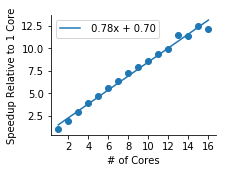

In [5]:
scaling_test['n_per_proc'] = scaling_test['Nmat'] / scaling_test['n_procs']
scaling_test['n_cores'] = scaling_test['n_procs'] // 32

scaling_test = scaling_test[scaling_test.n_cores != 60]

def add_speedup(df):
    min_row = df[df['n_cores'] == min(df['n_cores'])]
    single_core_time = np.average(min_row['total_calculation_time'] * min_row['n_cores'])
    df['Speedup'] = pd.to_numeric(single_core_time) / df['total_calculation_time']
    return df
    
scaling_test = scaling_test.groupby('NDIM').apply(add_speedup)


def linefit(x, y, **kwargs):
    """Wrapper to allow for varied scales in plots"""
    ax = plt.gca()

    plt.scatter(x, y, **kwargs)
  
    coeffs = np.polyfit(x, y, deg=1)
    poly = np.poly1d(coeffs)
    fitfunc = lambda x: poly(x)
    xvals = np.linspace(min(x), max(x), 500)
    line = plt.plot(xvals, fitfunc(xvals), label='{:5.2f}x +{:5.2f}'.format(*coeffs))
    legend = plt.legend(handles=line, loc=0)
    ax.add_artist(legend)
    
    
scaling_test = scaling_test.query('NDIM == 3')
grid = sns.FacetGrid(scaling_test, col='NDIM', sharey=False, sharex=False, size=2.5, aspect=1.3)
grid = grid.map(linefit, 'n_cores', 'Speedup').set_titles("")
grid.set_axis_labels('# of Cores', 'Speedup Relative to 1 Core')
#plt.suptitle('Strong Parallel Scaling')
plt.subplots_adjust(top=0.9)
from matplotlib.ticker import MaxNLocator
#...
ax = plt.gca()
#...

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig("../doc/images/parallel-scaling.eps", bbox_inches='tight')
plt.show()

## We're not using most of the data, drop it so the important info is easier to parse

In [6]:
unused = ['use_delta_1D', 'vol', 'twoE_parameter_1dCase', 'mv_time', 'mycase', 'computation_finished', 'computation_started',
       'cond_number', 'dav_blocksize', 'dav_its', 'dav_max_subsize',
       'dav_maxits', 'dav_min_eval', 'dav_nconv', 'dav_num_evals',
       'dav_singlet_a_minus_b', 'dav_singlet_a_plus_b', 'dav_time', 'dav_tol',
       'dav_triplet_a_minus_b', 'dav_triplet_a_plus_b', 'build_date', 'N_MV_PROD', 'Nocc', 'Nvir', 'total_calculation_time'
         , 'num_guess_evecs']

df = df.drop(columns=unused).rename(columns={'ground_state_degeneracy': 'multiplicity'})

sing = df.copy()
sing.rename(columns={'singlet_instability': 'instability'}, inplace=True)
sing.drop(columns='triplet_instability', inplace=True)
sing['instab_type'] = 'Singlet'

trip = df.copy()
trip.rename(columns={'triplet_instability': 'instability'}, inplace=True)
trip.drop(columns='singlet_instability', inplace=True)
trip['instab_type'] = 'Triplet'

df = pd.concat([sing, trip])
df.head()

,File,NDIM,Nexc,Nk,Nmat,deltaK,multiplicity,kf,kmax,n_procs,rs,Nkpoints,instability,time,instab_type
49,HFS_3d_32Nk_6.0_rs_aprRev.json,3,42079,32,42079,0.039982,32,0.319860,0.639720,128,6.0,32768,-0.004470,15844.0,Singlet
228,HFS_2d_54Nk_15.0_rs_aprRev.json,2,17875,54,17875,0.006984,8,0.094281,0.188562,128,15.0,2916,-0.010967,5751.0,Singlet
271,HFS_2d_64Nk_7.0_rs_aprRev.json,2,29297,64,29297,0.012627,8,0.202031,0.404061,128,7.0,4096,-0.017886,13192.0,Singlet
321,HFS_2d_54Nk_14.0_rs_aprRev.json,2,17875,54,17875,0.007483,8,0.101015,0.202031,128,14.0,2916,-0.011577,6385.0,Singlet
300,HFS_2d_54Nk_13.0_rs_aprRev.json,2,17875,54,17875,0.008058,8,0.108786,0.217571,128,13.0,2916,-0.012255,5789.0,Singlet


# Renaming to align with publication

rename the columns to latex and bind python variables from old to new names

In [7]:
Nk = '$N_k$'
rs = '$r_s$'
deltaK = '$\Delta K$' 
NDIM = 'D'
cross = 'Transition $r_{s}$'
instability = r'Lowest Eigenvalue of $\mathbf{H}$'
instab_type='type'

renames = {'Nk': Nk, 'rs': rs, 'deltaK': deltaK, 'NDIM': NDIM, 'instability': instability, 'instab_type': instab_type}

df.rename(columns=renames, inplace=True)

# Singlet Stability Curves

## Find where the instabilities cross zero

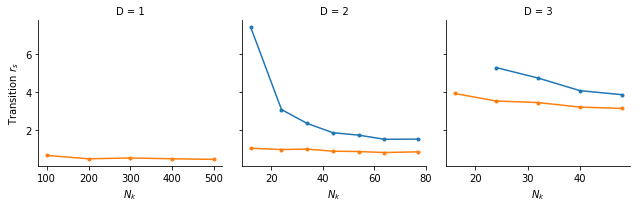

In [8]:
from scipy.interpolate import interp1d
from scipy import optimize

def crossover(df, x, y, interp1d_args=(), interp1d_kwargs=None):
    temp = df.dropna(subset=[x, y])
    
    try:
        x, y = temp[x], temp[y]
        
        if interp1d_kwargs is None:
            interp1d_kwargs = {}

        f = interp1d(x, y, *interp1d_args, **interp1d_kwargs)

        return optimize.brentq(f, min(x), max(x), xtol=0.001)
    except:
        return np.nan


onset = (df.groupby([Nk, NDIM, instab_type])
        .apply(lambda d: crossover(d, rs, instability))
        .reset_index()
        .rename(columns={0: cross})
).dropna()

grid = sns.FacetGrid(onset, col=NDIM, hue=instab_type, sharex=False)
grid.map(plt.plot, Nk, cross, marker='.')
plt.savefig('onset_vs_nk.eps')

In [9]:
from scipy import optimize as opt
import collections
import functools
import inspect
import pprint

class CurveFit(object):
       
    def __init__(self, xdata, ydata, func, func_kwargs=None, fit_args=(), fit_kwargs=None, zero_tol=1e-6):
        """Generate a fitting function for given form with xdata and ydata
        IMPORTANT: func must be of the form ydata = f(xdata, *args, **func_kwargs)
        
        """
        self.xdata = xdata
        self.ydata = ydata
        self._original_func = func

        sig = inspect.signature(func).parameters
        defaults = {i.name: i.default for i in sig.values() if not i.default == i.empty}

        # Apparently available since 3.5
        if func_kwargs is not None:
            func_kwargs = {**defaults, **func_kwargs}
        else:
            func_kwargs = defaults

        # Binding the keyword arguments so scipy isn't confused. 
        func = functools.partial(func, **func_kwargs)

        if fit_kwargs is None:
            fit_kwargs = {}

        params, pcov = opt.curve_fit(func, xdata, ydata, *fit_args,  **fit_kwargs)


        sig = collections.OrderedDict(sig)
        sig.popitem(last=False)
        fit_params = {name: param for name, param in zip(sig, params)}
        
        def suppress(val, tol):
            if abs(val) < tol:
                return 0.0
            else: 
                return val
            
        
        fit_params = {k: v for k, v in fit_params.items()}
        
        self.func = functools.partial(func, **fit_params)
        self.fit_params = fit_params
        self.all_params = {**func_kwargs, **fit_params}
        self.unfit_params = {k: suppress(v, zero_tol) for k, v in self.all_params.items() if k not in self.fit_params.keys()}
        self.covariance = pcov
    
    def __call__(self, xdata):
        return self.func(xdata)
    
    def __str__(self):
        s = ['Curve Fit object']
        s += ['Fit data to the function:']
        s += [self._original_func.__str__()]
        s += ['Parameters returned by curve fitting:']
        s += [pprint.pformat(self.fit_params)]
        s += ['Parameters explicitly specified (were not fit):']
        s += [pprint.pformat(self.unfit_params)]
        return '\n'.join(s)

In [10]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gb = df.dropna().groupby([instab_type, NDIM, Nk]).apply(lambda d: d.sort_values(rs)).groupby([instab_type, NDIM, Nk])
    

# Fit the data to the 1/r^n series

In [11]:
def fit_function(x, c1, c2, c3):
    
    return  c1/x  + c2/x**2 + c3/x**1.5


def fit(d):
    data = d[d[instability].between(-1, 0.3)]
    return CurveFit(data[rs], data[instability], fit_function, fit_kwargs={'p0': [ -0.8, -0.3, 1.0]})

curves = gb.apply(fit).apply(pd.Series)
temp = df.dropna().groupby([instab_type, NDIM, Nk]).apply(lambda d: {rs: d[rs].values, instability: d[instability].values})
temp = temp.apply(pd.Series)
temp['curve'] = curves
temp = temp.reset_index()

expanded = temp['curve'].apply(lambda row: pd.Series({**row.fit_params, 'func':row.func}))
fitstuff = pd.concat([temp, expanded], axis=1)

def all_roots(f, *, low, high, npoints=10**6, **kwargs):
    """Find all roots of f in the interval [low, high]. Forward args and kwargs to scipy.optimize.brentq"""
    x = np.linspace(low, high, npoints)
    y = f(x)
    idx, = np.where(np.abs(np.diff(np.sign(y))) > 1e-10)  # Where the sign changes occur
    begin = x[idx]
    end = x[idx + 1]
    bounds = np.stack((begin, end), axis=1)
    if len(bounds) == 0:
        return np.asarray([10**10])
    
    roots = []
    for lhs, rhs in bounds:
        try:
            root = optimize.brentq(f, lhs, rhs, **kwargs)
        except ValueError:
            root = 10**10
        roots.append(root)
    return np.asarray(roots)

def get_zeros(row, a=0.01, b=20):
    min_rs = row[rs].min()
    max_rs = row[rs].max()
    f = row['curve']
    roots = all_roots(f, low=a, high=b)
    return max(roots)

fitstuff['zeros'] = fitstuff.apply(get_zeros, axis='columns')

# Plot

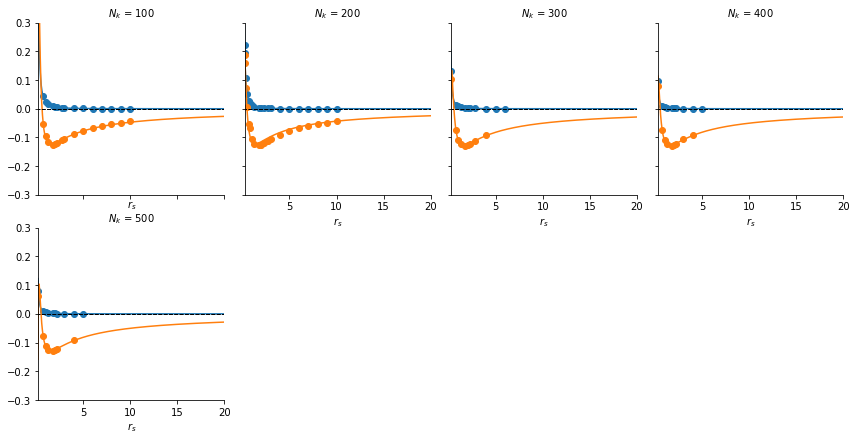

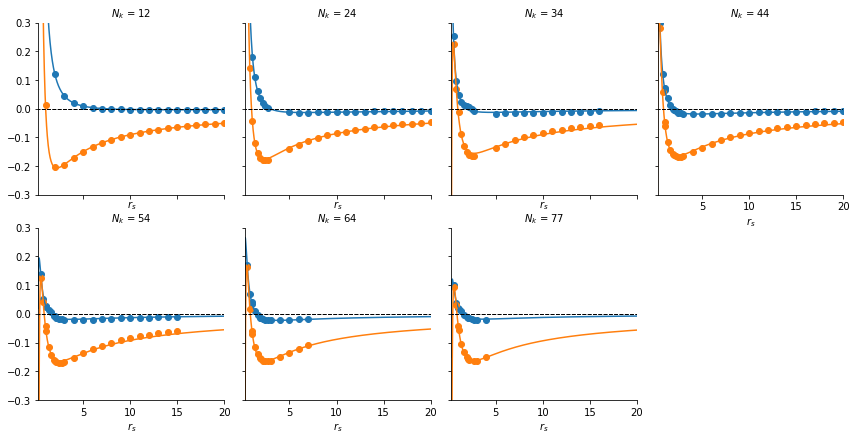

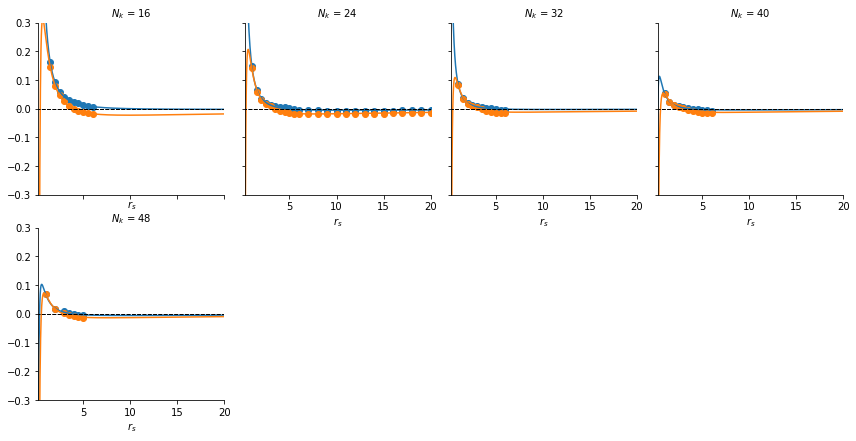

In [12]:
def hline(val, *args, **kwargs):
    x = np.linspace(-10**10, 10**10, 1000)
    ax = plt.gca()
    xlim = ax.get_xlim()
    y = np.ones_like(x) * val
    ax.plot(x, y, *args, **kwargs)
    ax.set_xlim(xlim)

x = np.linspace(0.2, 20, 1000)

def plotter(data, **kwargs):
    curvefit = data['curve'].iloc[0]
    plt.plot(x, curvefit(x), **kwargs)
    rs_ = data[rs].iloc[0]
    inst = data[instability].iloc[0]
    plt.scatter(rs_, inst, **kwargs)
    
    stdevs = np.sqrt(np.diag(curvefit.covariance))

for grp, d in fitstuff.groupby(NDIM):
    g = sns.FacetGrid(d, col=Nk, col_wrap=4, size=3, hue=instab_type)
    g = g.map_dataframe(plotter).set(xlim=(0.25, 20), ylim=(-0.3, 0.3))
    g = g.map(hline, val=0.0, color='k', linestyle='--', linewidth=1).set(xlabel=rs)


/home/evan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


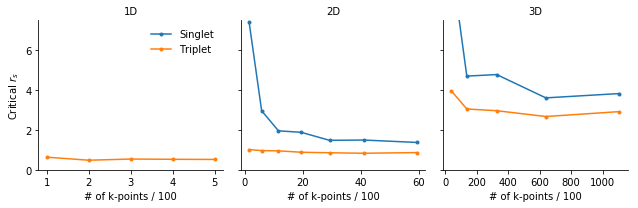

In [13]:
from matplotlib import ticker
temp = fitstuff[np.logical_or(fitstuff[NDIM] != 1, fitstuff[instab_type].str.match('Triplet'))]
temp['Nkpts'] = temp[Nk]**temp[NDIM] / 100
g = (
    sns.FacetGrid(temp, hue=instab_type, col=NDIM, size=3, sharex=False, sharey=True, legend_out=False)
    .map(plt.plot, 'Nkpts', 'zeros', marker='.')
    .add_legend(title='', frameon=False)
    .set_titles('{col_name}D')
    .set(xlabel='# of k-points / 100', ylim=(0, 7.5))
)
g.axes[0, 0].set_ylabel('Critical $r_s$')

plt.savefig('../doc/papers/paper_skeleton/onsets.eps')

# Single example plot of curve fitting

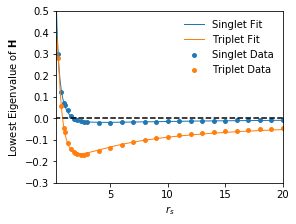

In [14]:
fig = plt.figure(constrained_layout=True, figsize=(4, 3))
s = fitstuff[(fitstuff[Nk] == 44) & fitstuff[instab_type].str.match('Singlet')].sort_values(rs)
t = fitstuff[(fitstuff[Nk] == 44) & fitstuff[instab_type].str.match('Triplet')].sort_values(rs)

xx = np.linspace(0.1, 20, 1000)
x = s[rs].iloc[0]
y = s[instability].iloc[0]
f = s['func'].iloc[0]

plt.scatter(x, y, label='Singlet Data', s=15)
plt.plot(xx, f(xx), label='Singlet Fit', lw=1)

x = t[rs].iloc[0]
y = t[instability].iloc[0]
f = t['func'].iloc[0]

plt.scatter(x, y, label='Triplet Data', s=15)
plt.plot(xx, f(xx), label='Triplet Fit', lw=1)
plt.xlabel(rs)
plt.ylabel(instability)
plt.ylim(-0.3, 0.5)
plt.xlim(0.35, 20)
plt.legend(frameon=False)
hline(0.0, 'k--')
plt.savefig('../doc/papers/paper_skeleton/fit_curves.eps')


# Fit analysis

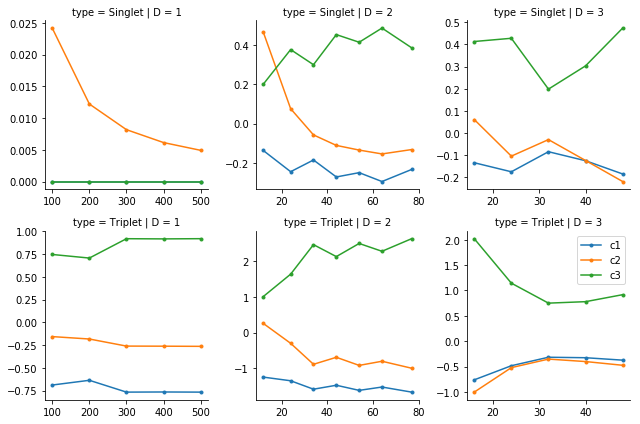

In [15]:
def plotter(data, **kwargs):
    d = data.set_index(Nk)[['c1', 'c2', 'c3']]
    d.plot(marker='.', ax=plt.gca(), legend=True)

grid = sns.FacetGrid(fitstuff, col=NDIM, row=instab_type, sharex=False, sharey=False)
grid.map_dataframe(plotter)
plt.legend()

# Idealized Curves

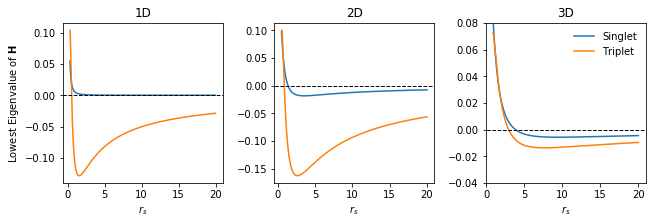

In [16]:
gb = fitstuff.groupby([NDIM, instab_type]).apply(lambda d: d[d[Nk] == d[Nk].max()][['c1', 'c2', 'c3', 'zeros']])


def add_hline(ax, val=0.0, **kwargs):
    x = np.linspace(-10**10, 10**10, 1000)
    xlim = ax.get_xlim()
    y = np.ones_like(x) * val
    ax.plot(x, y, 'k--', lw=1)
    ax.set_xlim(xlim)
    
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(9, 3), constrained_layout=True)
gb = gb.groupby([NDIM, instab_type])

x = np.linspace(0.3, 20, 1000)
c = gb.get_group((1, 'Singlet')).iloc[0]
ax1.plot(x, fit_function(x, *c[:-1]))
c = gb.get_group((1, 'Triplet')).iloc[0]
ax1.plot(x, fit_function(x, *c[:-1]))
add_hline(ax1)
ax1.set_title('1D')
ax1.set_xlabel(rs)
ax1.set_ylabel(instability)

x = np.linspace(0.5, 20, 1000)
c = gb.get_group((2, 'Singlet')).iloc[0]
ax2.plot(x, fit_function(x, *c[:-1]), label='Singlet')
c = gb.get_group((2, 'Triplet')).iloc[0]
ax2.plot(x, fit_function(x, *c[:-1]), label='Triplet')
add_hline(ax2)
ax2.set_title('2D')
ax2.set_xlabel(rs)

x = np.linspace(0.85, 20, 1000)
c = gb.get_group((3, 'Singlet')).iloc[0]
ax3.plot(x, fit_function(x, *c[:-1]), label='Singlet')
c = gb.get_group((3, 'Triplet')).iloc[0]
ax3.plot(x, fit_function(x, *c[:-1]), label='Triplet')
ax3.set_ylim(-0.04, 0.08)
add_hline(ax3)

ax3.set_xlabel(rs)
ax3.set_title('3D')

plt.legend(frameon=False)